In [ ]:
# This file is to simulate ordinary long distance ED with 3 nodes.

In [1]:
# This code cell is to define the circuit of ordinary long distance ED(3_nodes)
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
    phase_amplitude_damping_error,
)
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

qreg_q = QuantumRegister(4, 'q')
creg_c0 = ClassicalRegister(1, 'c0')
creg_c1 = ClassicalRegister(1, 'c1')
circuit = QuantumCircuit(qreg_q, creg_c0, creg_c1)

circuit.h(qreg_q[0])
circuit.h(qreg_q[2])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.cx(qreg_q[2], qreg_q[3])
circuit.cx(qreg_q[1], qreg_q[2])
circuit.h(qreg_q[1])
circuit.measure(qreg_q[1], creg_c0[0])
circuit.measure(qreg_q[2], creg_c1[0])
circuit.x(qreg_q[3]).c_if(creg_c1, 1)
circuit.z(qreg_q[3]).c_if(creg_c0, 1)
circuit.measure_all()
#circuit.draw("mpl")

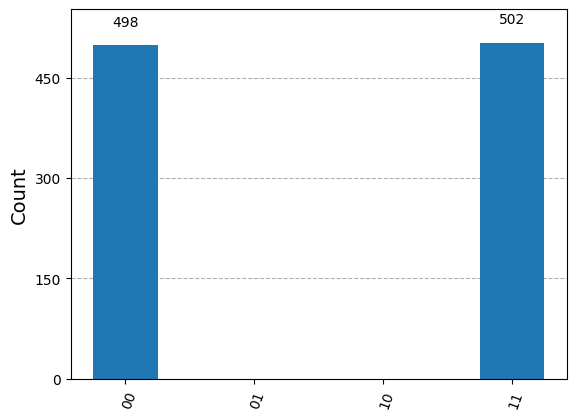

In [3]:
# This code cell is to simulate the ideal case(without noise)
sim_ideal = AerSimulator()
counts = sim_ideal.run(circuit,shots=1000).result().get_counts()
target_qubits_counts = {'00': 0, '01': 0,'10': 0,'11': 0}
for outcome, count in counts.items():
    target_qubits = outcome[3]+outcome[0]  # choose q0(outcome[3]) and q3(outcome[0])
    target_qubits_counts[target_qubits] += count
plot_histogram(target_qubits_counts)


/Users/ben/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


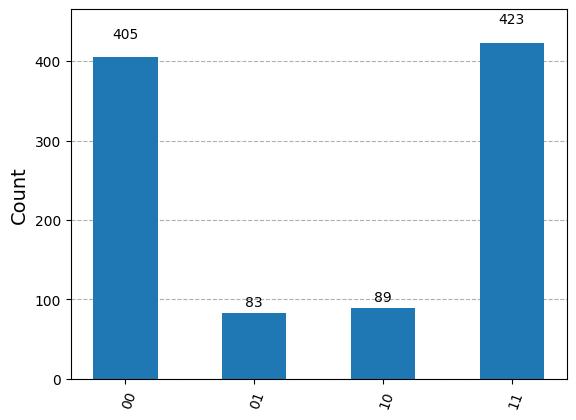

In [4]:
# This code cell is to simulate the realistic case(with noise).
# You can adjust the p_depo_01 and p_depo_23 to control the noise on two physical entanglements.
p_depo_01 = 0.2  # depolarizing error probability
p_depo_23 = 0.2
# QuantumError objects
depol_noise_q0q1 = depolarizing_error(p_depo_01, 2)
depol_noise_q2q3 = depolarizing_error(p_depo_23, 2)

# Create noisy simulator backend
noise_set = NoiseModel()
noise_set.add_quantum_error(depol_noise_q0q1, ['cx'], [0,1])
noise_set.add_quantum_error(depol_noise_q2q3, ['cx'], [2,3])
sim_noise = AerSimulator(noise_model=noise_set)

# Transpile circuit for noisy basis gates
passmanager = generate_preset_pass_manager(optimization_level=3, backend=sim_noise)
circuit_tnoise = passmanager.run(circuit)

#Run and get counts
counts = sim_noise.run(circuit_tnoise,shots=1000).result().get_counts()
#plot_histogram(counts)
target_qubits_counts = {'00': 0, '01': 0,'10': 0,'11': 0}
for outcome, count in counts.items():
    target_qubits = outcome[3]+outcome[0]  # choose q0(outcome[3]) and q3(outcome[0])
    target_qubits_counts[target_qubits] += count
plot_histogram(target_qubits_counts)

In [10]:
# This code cell is to calculate the throughput of ordinary long-distance ED(3_nodes). 
# We first derive the time cost of one long-distance entanglement distribution, and then calculate the throughput according to the time.
# The time cost consists of two parts:
#    a) the time cost of one short distance ED (The time cost of short distance ED is calculated from the speed of light and the length of the channel. Assuming that the length of the channel is 50km and the speed of light is 300000km/s, it takes about 0.16 ms for the local domain controller to complete the short distance ED of adjacent Repeaters. Short distance ED can be performed in parallel between different local domain controllers.)
#    b) the time cost of entanglement swapping. (It can be derived by following codes)
sim_ideal = AerSimulator()
es_time_3_nodes = sim_ideal.run(circuit,shots=1).result().time_taken

print(es_time_3_nodes)

ordinary_ED_total_time_3_nodes = 0.16 + es_time_3_nodes * 1000
ordinary_ED_throughput_3_nodes = 1/(ordinary_ED_total_time_3_nodes/100)
print(ordinary_ED_throughput_3_nodes)

0.0012519359588623047
70.82474199508098
